In [1]:
import itertools
import sys

sys.path.append("../")

In [2]:
import pandas as pd
import random
import itertools

from ptrail.core.Datasets import Datasets
from ptrail.core.TrajectoryDF import PTRAILDataFrame
from ptrail.features.kinematic_features import KinematicFeatures
from ptrail.preprocessing.statistics import Statistics
from src.augmentation.augment import Augmentation
from src.selection.select import Selection

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import f1_score, accuracy_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Load the dataset and create the distance column in it which is necessary for Augmentation.
starkey_data = Datasets.load_starkey()
ready_dataset = KinematicFeatures.create_distance_column(starkey_data).reset_index()

------------------------ Dataset Facts ------------------------------

Number of unique Trajectories in the data: 253
Number of points in the data: 287136
Dataset time range: 1196 days 22:51:45
Datatype of the DataFrame: <class 'ptrail.core.TrajectoryDF.PTRAILDataFrame'>
Dataset Bounding Box: (45.18896978643169, -118.61020848239596, 45.314545642992, -118.50455596234036)

---------------------------------------------------------------------


In [4]:
traj_ids = list(ready_dataset['traj_id'].unique())
train_size = int(len(traj_ids) * 0.90)

train_traj_ids = random.sample(traj_ids, train_size)
test_traj_ids = []
for t in traj_ids:
    if t not in train_traj_ids:
        test_traj_ids.append(t)

training, testing = ready_dataset.loc[ready_dataset.traj_id.isin(train_traj_ids)], \
    ready_dataset.loc[ready_dataset.traj_id.isin(test_traj_ids)]

In [5]:
myRandom = random.Random(1)
selected = Selection.select_randomly(training, myRandom, k=0.046)
selected

['910313E11',
 '950125E13',
 'OSUX92115',
 'OSUX92014',
 'OSUX91073',
 '890418E15',
 '930107E06',
 '910312E12',
 '940329E01',
 'OSUX91116']

In [6]:
%%time
# Augment each trajectory 20 times, first augment with the new point being in the circle 10 times.
# Then augment under the condition that the new point will be on the circle.

training = Augmentation.augment_trajectories_with_randomly_generated_points(training,
                                                                           random=myRandom,
                                                                           ids_to_augment=selected,
                                                                           circle='in')

for i in range(1, 6):
    training = Augmentation.augment_trajectories_with_randomly_generated_points(training,
                                                                               random=myRandom,
                                                                               ids_to_augment=selected,
                                                                               circle='in')


for i in range(0, 6):
    training = Augmentation.augment_trajectories_with_randomly_generated_points(training,
                                                                               random=myRandom,
                                                                               ids_to_augment=selected,
                                                                               circle='on')

training

CPU times: user 16.4 s, sys: 179 ms, total: 16.6 s
Wall time: 16.6 s


,traj_id,DateTime,lat,lon,StarkeyTime,GMDate,GMTime,LocDate,LocTime,RadNum,Species,UTME,UTMN,Year,Grensunr,Grensuns,Obswt,Distance
0,880109D01,1995-04-13 13:40:06,45.239682,-118.533204,229902006,21:40:06,19950413,19950413,13:40:06,409,0,379662,5010734,95,13:13:00,02:39:00,1.47,NaN
1,880109D01,1995-04-15 12:16:15,45.250521,-118.530438,230069775,20:16:15,19950415,19950415,12:16:15,409,0,379895,5011927,95,13:09:00,02:41:00,1.59,1224.551334
2,880109D01,1995-04-15 21:39:38,45.247943,-118.541455,230103578,05:39:38,19950416,19950415,21:39:38,409,0,379039,5011656,95,13:07:00,02:43:00,1.34,908.878736
3,880109D01,1995-04-16 03:32:14,45.247429,-118.539530,230124734,11:32:14,19950416,19950416,03:32:14,409,0,379188,5011581,95,13:07:00,02:43:00,1.50,161.204428
4,880109D01,1995-04-16 04:08:28,45.247117,-118.542579,230126908,12:08:28,19950416,19950416,04:08:28,409,0,378938,5011567,95,13:07:00,02:43:00,1.34,241.258531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284146,OSUX92115aug8852153,1996-08-15 06:33:46,45.211255,-118.543115,272212426,14:33:46,19960815,19960815,06:33:46,179,2,380238,5008415,96,12:56:00,03:04:00,1.65,256.418398
284147,OSUX92115aug8852153,1996-08-15 08:28:01,45.217721,-118.529554,272219281,16:28:01,19960815,19960815,08:28:01,179,2,380246,5008468,96,12:56:00,03:04:00,1.56,60.045136
284148,OSUX92115aug8852153,1996-08-15 10:19:38,45.218635,-118.527090,272225978,18:19:38,19960815,19960815,10:19:38,179,2,380269,5008470,96,12:56:00,03:04:00,1.56,29.922581
284149,OSUX92115aug8852153,1996-08-15 12:13:42,45.196785,-118.601242,272232822,20:13:42,19960815,19960815,12:13:42,179,2,380075,5009532,96,12:56:00,03:04:00,1.38,1065.993620


In [7]:
# Generate kinematic statistics on the dataset and then convert
# the dataset from point-form representation into traj-form representation.
pivoted_train = Statistics.pivot_stats_df(
    dataframe=Statistics.generate_kinematic_stats(training, 'Species'),
    target_col_name='Species')

# Pivoting the test data
pivoted_test = Statistics.pivot_stats_df(
    dataframe=Statistics.generate_kinematic_stats(testing, 'Species'),
    target_col_name='Species')
pivoted_train

,10%_Distance,25%_Distance,50%_Distance,75%_Distance,90%_Distance,min_Distance,max_Distance,mean_Distance,std_Distance,10%_Distance_from_start,...,10%_Rate_of_bearing_rate,25%_Rate_of_bearing_rate,50%_Rate_of_bearing_rate,75%_Rate_of_bearing_rate,90%_Rate_of_bearing_rate,min_Rate_of_bearing_rate,max_Rate_of_bearing_rate,mean_Rate_of_bearing_rate,std_Rate_of_bearing_rate,Species
traj_id,,,,,,,,,,,,,,,,,,,,,
910313E37,30.022359,66.956787,149.611989,300.726867,632.269559,0.000000,6034.207873,268.728974,398.901980,1121.185006,...,-0.063322,-0.026677,5.306679e-08,0.025072,0.065316,-6.036678,2.449554,-0.001945,0.154034,1
890424E08,42.384642,84.780370,177.223376,379.614004,759.311144,0.000000,6043.490157,323.956468,446.249248,674.170024,...,-0.064023,-0.023545,0.000000e+00,0.022320,0.063820,-11.536372,2.494857,-0.006703,0.241358,1
921228E06,42.390114,90.066813,200.849995,429.158672,890.194719,0.000000,4623.347553,377.677630,517.650637,807.693739,...,-0.058033,-0.020736,-9.056581e-07,0.020104,0.056057,-56.020652,4.466711,-0.016681,1.008263,1
940110D01,30.022192,66.956668,149.612107,284.710015,510.276991,0.000000,1975.611748,221.420080,235.093739,492.522877,...,-0.041207,-0.018263,0.000000e+00,0.018564,0.042032,-5.547235,200.192244,0.073830,3.677063,0
890130D09,42.384166,67.089952,149.800390,300.728973,557.198936,0.000000,3647.436664,243.836142,288.048277,805.405461,...,-0.043139,-0.018251,2.372532e-09,0.017504,0.043053,-39.481716,3.244600,-0.016979,0.761028,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OSUX92071,42.384783,98.213522,275.921086,509.415791,1734.539050,0.000000,4968.850596,552.252200,797.302786,2019.896767,...,-0.013195,-0.006290,-1.456657e-04,0.006863,0.019363,-0.180602,0.032870,-0.001012,0.022347,2
OSUX92008,60.044073,113.846901,323.971240,582.606358,1036.441333,0.000000,3252.044721,469.226709,565.038959,2330.556507,...,-0.033016,-0.006065,4.739615e-05,0.008182,0.023711,-0.119311,0.119162,-0.001884,0.033022,2
OSUX91121,66.956676,138.476526,334.746006,596.234364,1365.947767,42.390056,5886.617958,652.055638,1119.869470,2660.409775,...,-0.010799,-0.003606,1.840711e-04,0.006951,0.023679,-0.018316,0.027926,0.001982,0.011728,2


0.9607223015711079


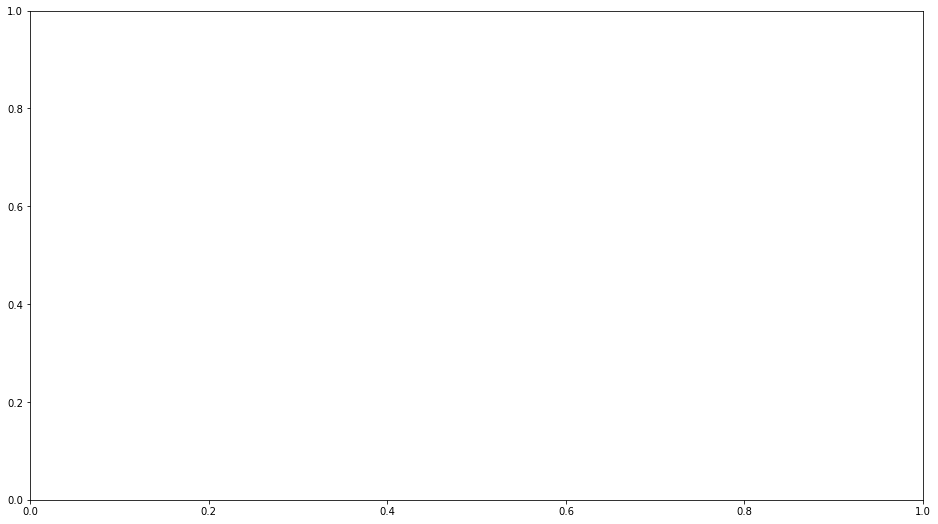

In [8]:
# Predicting the results for the original dataset.
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
model = RandomForestClassifier()
scaler = MinMaxScaler(feature_range=(0, 1))
pca = PCA(n_components=2)


X_train, Y_train = pivoted_train.drop(columns=['Species']), pivoted_train['Species']
X_test, Y_test = pivoted_test.drop(columns=['Species']), pivoted_test['Species']

scaled_trainX = scaler.fit_transform(X_train)
scaled_testX = scaler.fit_transform(X_test)
pcaXTrain = pca.fit_transform(scaled_trainX)
pcaXTest = pca.fit_transform(scaled_testX)
# for i in range(len(pcaXTrain)):
#     if 'aug' in X_train.reset_index().iloc[i].traj_id:
#         ax.scatter(pcaXTrain[:, 0], pcaXTrain[:, 1], c='green', s=225)
#     else:
#         ax.scatter(pcaXTrain[:, 0], pcaXTrain[:, 1], c='red', s=150)




model.fit(X_train, Y_train)

predicted = model.predict(X_test)
prediction_score = f1_score(list(Y_test), list(predicted), average='weighted')
print(prediction_score)
# fig.tight_layout()

In [11]:
pivoted_train.to_csv('./train.csv')